In [1]:
%cd '/content/drive/MyDrive/Colab Notebooks/stepik/m4. inference/w4. tasks'
!ls

/content/drive/MyDrive/Colab Notebooks/stepik/m4. inference/w4. tasks
'4.2 bioinformatics.ipynb'   ab_browser_test.csv
'4.3 from github.ipynb'      churn_analysis.csv
'4.3 scoring.ipynb'	     credit_card_default_analysis.csv
'4.3 tests.ipynb'	    'default analysis peer review.ipynb'
'4.4 ab testing.ipynb'	     gene_high_throughput_sequencing.csv
'4.5 churn analysis.ipynb'  'peer work scoring.ipynb'


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from scipy import stats
from statsmodels.stats.multitest import multipletests
from itertools import combinations
from tqdm import tqdm
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.multitest import multipletests


In [4]:
data = pd.read_csv('churn_analysis.csv', index_col=0)
data['churn'] = data['churn'].apply(lambda x: 1 if x == 'True.' else 0)
data_control = data[data['treatment'] == 1]
data_treatment_1 = data[data['treatment'] == 0]
data_treatment_2 = data[data['treatment'] == 2]
data.head()

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim,churn
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,1,0.65,0
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,0.55,0
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,0.72,0
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,1,0.28,0
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,2,0.45,0


In [5]:
states = data['state'].unique()
cross_tabs = []
for state_pair in tqdm(list(combinations(states, 2))):
    df = data_control[data['state'].isin(state_pair)]
    cross_tabs.append(pd.crosstab(df['state'], df['churn']))
len(cross_tabs)

100%|██████████| 1275/1275 [00:15<00:00, 82.85it/s]


1275

In [6]:
pvalues_chi2 = [stats.chi2_contingency(ct, correction=False)[1] for ct in cross_tabs]

In [7]:
pvalues_chi2_yates = [stats.chi2_contingency(ct)[1] for ct in cross_tabs]

In [8]:
pvalues_fisher = [stats.fisher_exact(ct)[1] for ct in cross_tabs]

In [9]:
print(len([pv for pv in pvalues_chi2 if pv < 0.05]))
print(len([pv for pv in pvalues_chi2_yates if pv < 0.05]))
print(len([pv for pv in pvalues_fisher if pv < 0.05]))


34
0
10


In [10]:
print(np.mean(pvalues_chi2), np.mean(pvalues_chi2_yates), np.mean(pvalues_fisher))

0.5018273798739158 0.6640566382051046 0.6483383060020682


In [11]:
stats.pearsonr(data['day_calls'], data['mes_estim'])

(-0.05179435058757264, 0.0027798836869738384)

In [12]:
stats.spearmanr(data['day_calls'], data['mes_estim'])

SpearmanrResult(correlation=0.043349880533927444, pvalue=0.012317367189170541)

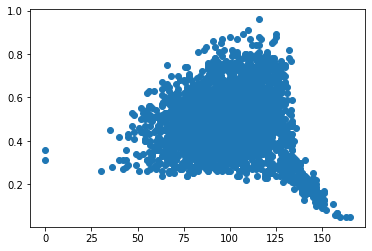

In [13]:
plt.scatter(data['day_calls'], data['mes_estim'])
plt.show()

In [ ]:
cont_table = pd.crosstab(data_control['state'], data_control['churn'])
stats.chi2_contingency(cont_table)

In [15]:
def get_ratio(vals):
    return sum(vals) / len(vals)

In [16]:
churn_control = data_control['churn']
churn_treatment_1 = data_treatment_1['churn']
churn_treatment_2 = data_treatment_2['churn']
print(get_ratio(churn_control))
print(get_ratio(churn_treatment_1))
print(get_ratio(churn_treatment_2))

0.1640838650865998
0.14563106796116504
0.12511332728921123


In [17]:
def get_conf_int(vals):
    return proportion_confint(sum(vals), vals.shape[0], method = 'wilson')

print(get_conf_int(churn_control))
print(get_conf_int(churn_treatment_1))
print(get_conf_int(churn_treatment_2))

(0.14334706983717693, 0.18716506331819044)
(0.1262891297794312, 0.16736787598019826)
(0.1068800961786988, 0.14594875893019524)


In [18]:
def get_confint_by_prob(p1, p2, n1, n2, alpha=0.05):
    z = stats.norm.ppf(1 - alpha / 2.)
    delta = z * np.sqrt(p1 * (1 - p1) / n1 + p2 * (1 - p2) / n2)
    left_boundary = (p1 - p2) - delta
    right_boundary = (p1 - p2) + delta
    
    return (left_boundary, right_boundary)

def proportions_confint_diff_ind(sample1, sample2, alpha=0.05):    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    return get_confint_by_prob(p1, p2, len(sample1), len(sample2), alpha)
    
print(proportions_confint_diff_ind(churn_control, churn_treatment_1))
print(proportions_confint_diff_ind(churn_control, churn_treatment_2))
print(proportions_confint_diff_ind(churn_treatment_1, churn_treatment_2))

(-0.011583241590025106, 0.04848883584089464)
(0.00961876673809212, 0.06832230885668503)
(-0.007820886720395197, 0.04885636806430281)


In [24]:
def proportions_test(sample1, sample2):
    p1 = get_ratio(sample1)
    p2 = get_ratio(sample2)
    n1, n2 = len(sample1), len(sample2)
    p = (p1 * n1 + p2 * n2) / (n1 + n2)
    stdev = np.sqrt(p * (1 - p) * (1 / n1 + 1 / n2))
    zscore = np.abs(p1 - p2) / stdev
    pvalue = 1 - stats.norm.cdf(zscore)
    return pvalue

pvalues = []
pvalues.append(proportions_test(churn_control, churn_treatment_1))
pvalues.append(proportions_test(churn_control, churn_treatment_2))
pvalues.append(proportions_test(churn_treatment_2, churn_treatment_1))
pvalues

[0.11416558195225535, 0.0046740421472255544, 0.0782123443025401]

In [26]:
multipletests(pvalues, alpha=0.025, method='holm')

(array([False,  True, False]),
 array([0.15642469, 0.01402213, 0.15642469]),
 0.008403758659612626,
 0.008333333333333333)

In [20]:
# another way, from lectures
def get_zscore(sample1, sample2):
    p1 = get_ratio(sample1)
    p2 = get_ratio(sample2)
    n1, n2 = len(sample1), len(sample2)
    zscore = np.abs(p1 - p2) / np.sqrt(p1 * (1 - p1) / n1 + p2 * (1 - p2) / n2)
    pvalue = 1 - stats.norm.cdf(zscore)
    return zscore, pvalue

print(get_zscore(churn_control, churn_treatment_1))
print(get_zscore(churn_control, churn_treatment_2))
print(get_zscore(churn_treatment_2, churn_treatment_1))

(1.2041141018126644, 0.11427274008148391)
(2.6022569604653114, 0.004630621596240725)
(1.4190536543777446, 0.07794168708229643)
